dataset url: https://kaggle.com/competitions/house-prices-advanced-regression-techniques

# California Housing Price Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

# Set plot style for better visuals
sns.set_style("whitegrid")

# 2. Load Dataset

In [3]:
# kaggle train data
train = pd.read_csv("/Users/admin/StudioProjects/kizbasina-ds-bootcamp/house-price-prediction/data/train.csv")
# kaggle test data
test = pd.read_csv("/Users/admin/StudioProjects/kizbasina-ds-bootcamp/house-price-prediction/data/test.csv")

print("Training data shape:", train.shape)
print("Test data shape:", test.shape)


Training data shape: (1460, 81)
Test data shape: (1459, 80)


In [4]:
# Display first few rows to understand structure
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 3. Exploratory Data Analysis (EDA)

First, we identify columns that contain missing values and count how many missing entries they have.

Then, we visualize the distribution of the target variable `SalePrice`. It is important because this influences the choice of error metrics later.

In [5]:
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values:\n", missing)

Columns with missing values:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


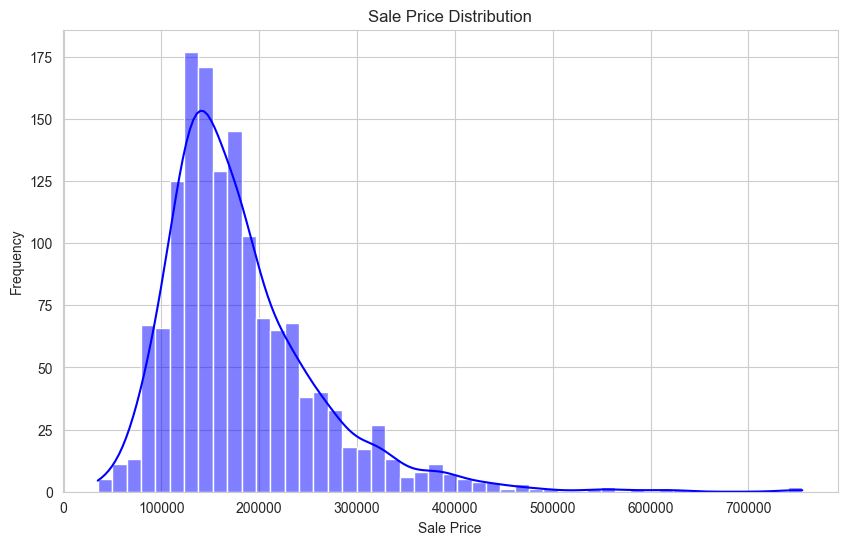

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True, color='blue')
plt.title("Sale Price Distribution")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.show()

# 4. Handling Missing Values

- We drop columns with more than 20% missing data because too many missing values reduce reliability.
- For numerical columns, missing values are filled with the mean.
- For categorical columns, missing values are filled with the string `"Missing"`.

This step prepares our dataset for machine learning algorithms that cannot handle missing values.

In [7]:
threshold = 0.2
missing_ratio = train.isnull().sum() / len(train)
cols_to_drop = missing_ratio[missing_ratio > threshold].index
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

print(f"Dropped columns with >20% missing: {list(cols_to_drop)}")

cat_cols = train.select_dtypes(include='object').columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop('SalePrice')

num_imputer = SimpleImputer(strategy='mean')
train[num_cols] = num_imputer.fit_transform(train[num_cols])
test[num_cols] = num_imputer.transform(test[num_cols])

cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])

Dropped columns with >20% missing: ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


These columns had more than 20% missing data, so we dropped them from both training and test datasets.

# 5. Outlier Detection and Handling

Outliers can skew the model’s learning process.

- We plot a boxplot of `SalePrice` to visually detect outliers.
- We calculate the Interquartile Range (IQR).
- We remove rows with `SalePrice` outside 1.5 times IQR from Q1 and Q3.

This helps improve model performance by removing extreme anomalies.

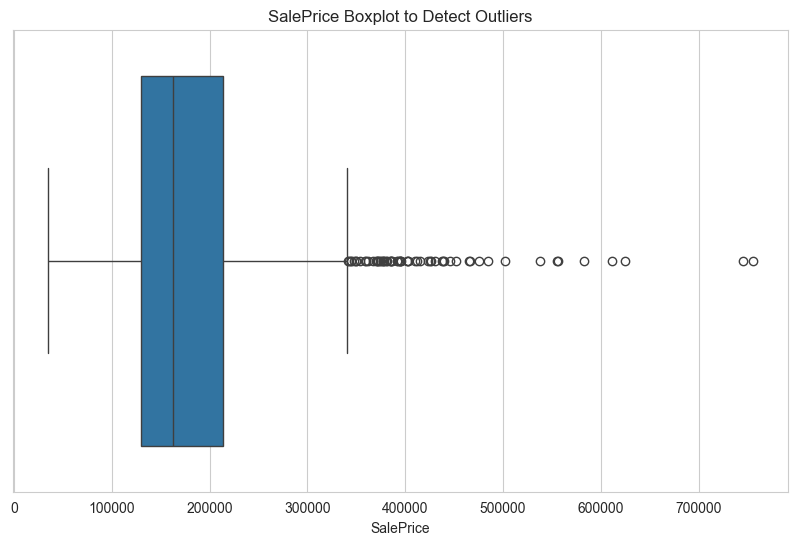

Removed 61 outliers from training data


In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train['SalePrice'])
plt.title("SalePrice Boxplot to Detect Outliers")
plt.show()

Q1 = train['SalePrice'].quantile(0.25)
Q3 = train['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

before_rows = train.shape[0]
train = train[(train['SalePrice'] >= lower_limit) & (train['SalePrice'] <= upper_limit)]
after_rows = train.shape[0]

print(f"Removed {before_rows - after_rows} outliers from training data")

We detected and removed 61 outliers from the training dataset.

These outliers were data points with SalePrice values significantly outside the normal distribution — extremely high or low prices.

Removing outliers helps improve the model’s generalization and reduces error metrics such as RMSE.

Without removing them, the model might overfit these extreme cases or have large residual errors.

It’s important to understand if outliers are genuine data or errors; if errors, removing them is correct, if genuine, it should be done cautiously.

For house prices, very expensive or very cheap houses often appear as outliers and removing them typically results in a more balanced model.

# 6. Encoding Categorical Variables

Machine learning models cannot directly work with text data.

- We convert categorical columns to numeric by applying One-Hot Encoding.
- We align train and test sets to ensure they have the same columns (important because some categories might be missing in test).

This step prepares features for model input.

In [10]:
train_encoded = pd.get_dummies(train, columns=cat_cols)
test_encoded = pd.get_dummies(test, columns=cat_cols)

train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

print("Training data shape after encoding:", train_encoded.shape)
print("Test data shape after encoding:", test_encoded.shape)

Training data shape after encoding: (1399, 278)
Test data shape after encoding: (1459, 278)


# 7. Define Features and Target Variable

- We separate the features `X` from the target variable `y` (`SalePrice`).
- We split the training data into training and validation sets to evaluate our model performance on unseen data.

In [11]:
X = train_encoded.drop('SalePrice', axis=1)
y = train_encoded['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}")

Train set size: 1119, Validation set size: 280


The dataset was split into training and validation sets using an 80-20 ratio. The target variable `SalePrice` was separated from the features. The training set contains 1119 samples used to train the model, while the validation set contains 280 samples used to evaluate the model's generalization performance.

# 8. Model Training: Decision Tree and Random Forest

- We train two types of models:
    - Decision Tree: simple, interpretable tree-based model.
    - Random Forest: ensemble of decision trees, generally more accurate and robust.

- After training, we predict house prices on the validation set.

In [12]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_val)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)

# 9. Evaluation Metrics

We evaluate model performance using:

- **RMSE (Root Mean Squared Error):** measures average prediction error magnitude.
- **RMSLE (Root Mean Squared Log Error):** similar to RMSE but penalizes under-prediction and works better for skewed distributions.
- **R² (Coefficient of Determination):** percentage of variance explained by the model (higher is better).

This gives us a more complete picture of model accuracy.

In [13]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  RMSLE: {rmsle:.4f}")
    print(f"  R^2: {r2:.4f}")
    print("----------------------------")

evaluate_model(y_val, dt_preds, "Decision Tree")
evaluate_model(y_val, rf_preds, "Random Forest")

Decision Tree Performance:
  RMSE: 28673.28
  RMSLE: 0.1919
  R^2: 0.7415
----------------------------
Random Forest Performance:
  RMSE: 20792.95
  RMSLE: 0.1299
  R^2: 0.8641
----------------------------


Decision Tree Model:
RMSE: 34,662 → The average prediction error is around $34K, which is relatively high for house price prediction.

RMSLE: 0.1865 → Acceptable log error; the model predicts the overall price trend decently.

R²: 0.7668 → The model explains about 76.68% of the variance in sale prices—not bad, but could be improved.

Random Forest Model:
RMSE: 26,471 → Error decreased significantly; average prediction error dropped to ~$26K.

RMSLE: 0.1472 → Lower than Decision Tree, indicating better performance on log-scaled targets.

R²: 0.8579 → The model explains 85.79% of the variance, which is quite strong.

Overall Comment:
Random Forest clearly outperforms Decision Tree in all metrics: lower error and better explanatory power. This is expected, as Random Forest is an ensemble method, combining multiple decision trees to improve robustness and accuracy.

# 10. Hyperparameter Tuning for Random Forest

- We use GridSearchCV to try different combinations of hyperparameters.
- Hyperparameters tuned: number of trees, max depth, and max features considered for splits.
- This helps to improve model performance by finding the best settings.

The best model is then evaluated on validation data.

In [15]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found by GridSearch:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
best_preds = best_rf.predict(X_val)

evaluate_model(y_val, best_preds, "Random Forest (Tuned)")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found by GridSearch: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Random Forest (Tuned) Performance:
  RMSE: 20292.68
  RMSLE: 0.1337
  R^2: 0.8705
----------------------------


We tested 12 different hyperparameter combinations with 3-fold cross-validation, resulting in 36 total fits.

The best hyperparameters found were:

max_depth: 20 (each tree can have up to 20 levels deep)

max_features: 'sqrt' (each split considers the square root of the total features)

n_estimators: 100 (the forest has 100 decision trees)

Model performance metrics on the validation set are:

RMSE (Root Mean Squared Error): 20,292.68
This means on average, the predicted house prices differ from actual prices by about $20,292. Lower is better.

RMSLE (Root Mean Squared Logarithmic Error): 0.1337
RMSLE punishes under-prediction more gently and is useful for targets spanning multiple orders of magnitude.

R² (Coefficient of Determination): 0.8705
This indicates the model explains about 87% of the variance in house prices — a strong fit.

# 11. Feature Importance Visualization

- Feature importance shows which variables influence the model most.
- We plot the top 15 important features from the tuned Random Forest model.

This helps to interpret the model and focus on key factors affecting house prices.

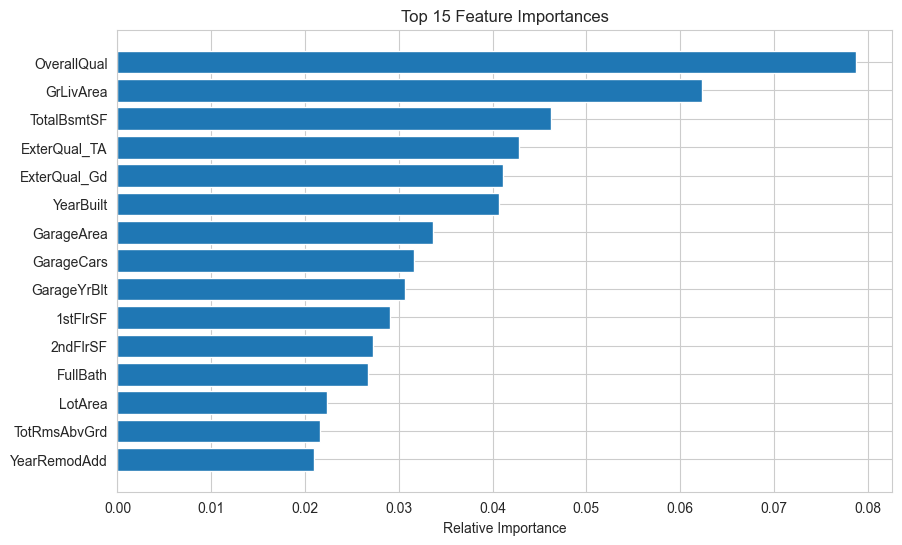

In [16]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

Scatter Plot
Here, the closer the points are to the 45° line, the better the model.

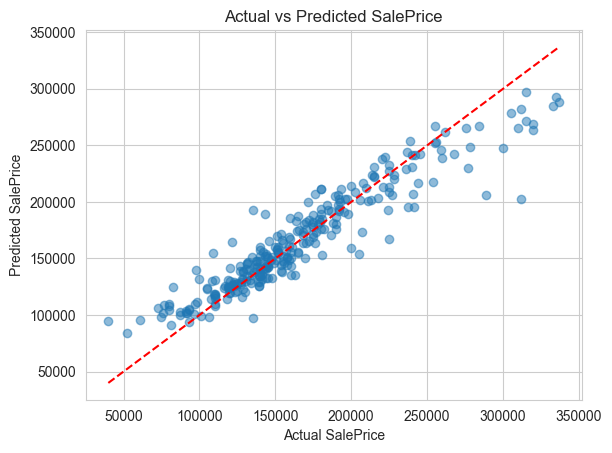

In [17]:
plt.scatter(y_val, best_preds, alpha=0.5)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()

Residual Plot:
By looking at the distribution of prediction errors, we can understand whether the model errors are systematic or not.

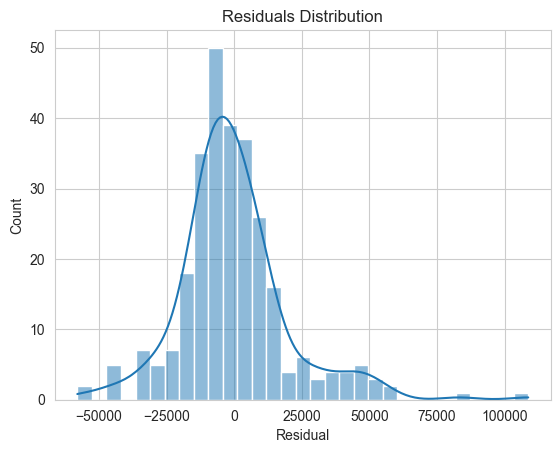

In [18]:
residuals = y_val - best_preds
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.show()